<a href="https://colab.research.google.com/github/kumkum-k/EV-Energy-Forecasting-Edunet-Cycle-4/blob/main/EV_ENERGY_FORECASTING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EV ENERGY FORECASTING USING ML**

## Setup and Data Loading
This notebook analyzes an Electric Vehicle (EV) energy consumption dataset from Kaggle to build a predictive model. The dataset contains 5,000 records with 19 features tracking EV operational parameters across approximately 3.5 days (January 1-4, 2024).

In [17]:
df = pd.read_csv('/content/EV_Energy_Consumption_Dataset.csv')

In [18]:

# Install required libraries
!pip install optuna xgboost lightgbm catboost scikit-learn pandas numpy matplotlib seaborn -q

# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# ML Algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna

# Set random seed for reproducibility
np.random.seed(42)


### Let's start by examining the basic structure and statistics of the dataset.

Dataset Info

In [19]:
print("\nDataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Vehicle_ID              5000 non-null   int64  
 1   Timestamp               5000 non-null   object 
 2   Speed_kmh               5000 non-null   float64
 3   Acceleration_ms2        5000 non-null   float64
 4   Battery_State_%         5000 non-null   float64
 5   Battery_Voltage_V       5000 non-null   float64
 6   Battery_Temperature_C   5000 non-null   float64
 7   Driving_Mode            5000 non-null   int64  
 8   Road_Type               5000 non-null   int64  
 9   Traffic_Condition       5000 non-null   int64  
 10  Slope_%                 5000 non-null   float64
 11  Weather_Condition       5000 non-null   int64  
 12  Temperature_C           5000 non-null   float64
 13  Humidity_%              5000 non-null   float64
 14  Wind_Speed_ms           5

First 5 Rows

In [20]:
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())


Dataset Shape: (5000, 19)

First 5 rows:
   Vehicle_ID            Timestamp   Speed_kmh  Acceleration_ms2  \
0        1102  2024-01-01 00:00:00  111.507366         -2.773816   
1        1435  2024-01-01 00:01:00   48.612323         -0.796982   
2        1860  2024-01-01 00:02:00  108.733320          0.253800   
3        1270  2024-01-01 00:03:00   38.579484         -2.111395   
4        1106  2024-01-01 00:04:00   57.172438          1.477883   

   Battery_State_%  Battery_Voltage_V  Battery_Temperature_C  Driving_Mode  \
0        30.415148         378.091525              25.314786             2   
1        97.385534         392.718377              18.240755             1   
2        84.912600         398.993495              44.449145             1   
3        28.777904         358.128273              28.980155             1   
4        29.740160         310.888162              33.184551             2   

   Road_Type  Traffic_Condition   Slope_%  Weather_Condition  Temperature_C  \
0 

Basic Statistics

In [21]:
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
        Vehicle_ID    Speed_kmh  Acceleration_ms2  Battery_State_%  \
count  5000.000000  5000.000000       5000.000000      5000.000000   
mean   1505.701200    59.312952         -0.019885        60.214465   
std     290.836902    34.517605          1.724287        23.128262   
min    1000.000000     0.001396         -2.999683        20.020196   
25%    1253.000000    29.515400         -1.490240        40.088318   
50%    1510.000000    58.646794         -0.043329        60.490283   
75%    1761.000000    89.030001          1.473887        80.409928   
max    1999.000000   119.946924          2.998039        99.993986   

       Battery_Voltage_V  Battery_Temperature_C  Driving_Mode    Road_Type  \
count        5000.000000            5000.000000   5000.000000  5000.000000   
mean          351.118306              27.510130      2.011000     1.999200   
std            28.968372              10.015385      0.810068     0.808536   
min           300.004812              

## Exploratory Data Analysis
Check data quality (missing values, duplicates) and analyze feature relationships with the target variable via correlation and visualization.

In [22]:
# Check missing values
print("\n" + "="*60)
print("MISSING VALUES ANALYSIS")
print("="*60)
print(df.isnull().sum())

# Check duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Analyze categorical features
print("\n" + "="*60)
print("CATEGORICAL FEATURES ANALYSIS")
print("="*60)
categorical_cols = ['Driving_Mode', 'Road_Type', 'Traffic_Condition', 'Weather_Condition']
for col in categorical_cols:
    print(f"\n{col}: {sorted(df[col].unique())}")
    print(df[col].value_counts())

# Correlation analysis
print("\n" + "="*60)
print("CORRELATION WITH TARGET VARIABLE")
print("="*60)
df_temp = df.copy()
df_temp['Timestamp'] = pd.to_datetime(df_temp['Timestamp'])
numeric_cols = df_temp.select_dtypes(include=[np.number]).columns
correlations = df_temp[numeric_cols].corr()['Energy_Consumption_kWh'].sort_values(ascending=False)
print(correlations)


MISSING VALUES ANALYSIS
Vehicle_ID                0
Timestamp                 0
Speed_kmh                 0
Acceleration_ms2          0
Battery_State_%           0
Battery_Voltage_V         0
Battery_Temperature_C     0
Driving_Mode              0
Road_Type                 0
Traffic_Condition         0
Slope_%                   0
Weather_Condition         0
Temperature_C             0
Humidity_%                0
Wind_Speed_ms             0
Tire_Pressure_psi         0
Vehicle_Weight_kg         0
Distance_Travelled_km     0
Energy_Consumption_kWh    0
dtype: int64

Duplicate rows: 0

CATEGORICAL FEATURES ANALYSIS

Driving_Mode: [np.int64(1), np.int64(2), np.int64(3)]
Driving_Mode
2    1719
3    1668
1    1613
Name: count, dtype: int64

Road_Type: [np.int64(1), np.int64(2), np.int64(3)]
Road_Type
2    1732
1    1636
3    1632
Name: count, dtype: int64

Traffic_Condition: [np.int64(1), np.int64(2), np.int64(3)]
Traffic_Condition
2    1702
3    1676
1    1622
Name: count, dtype: int64

Wea

Visualization

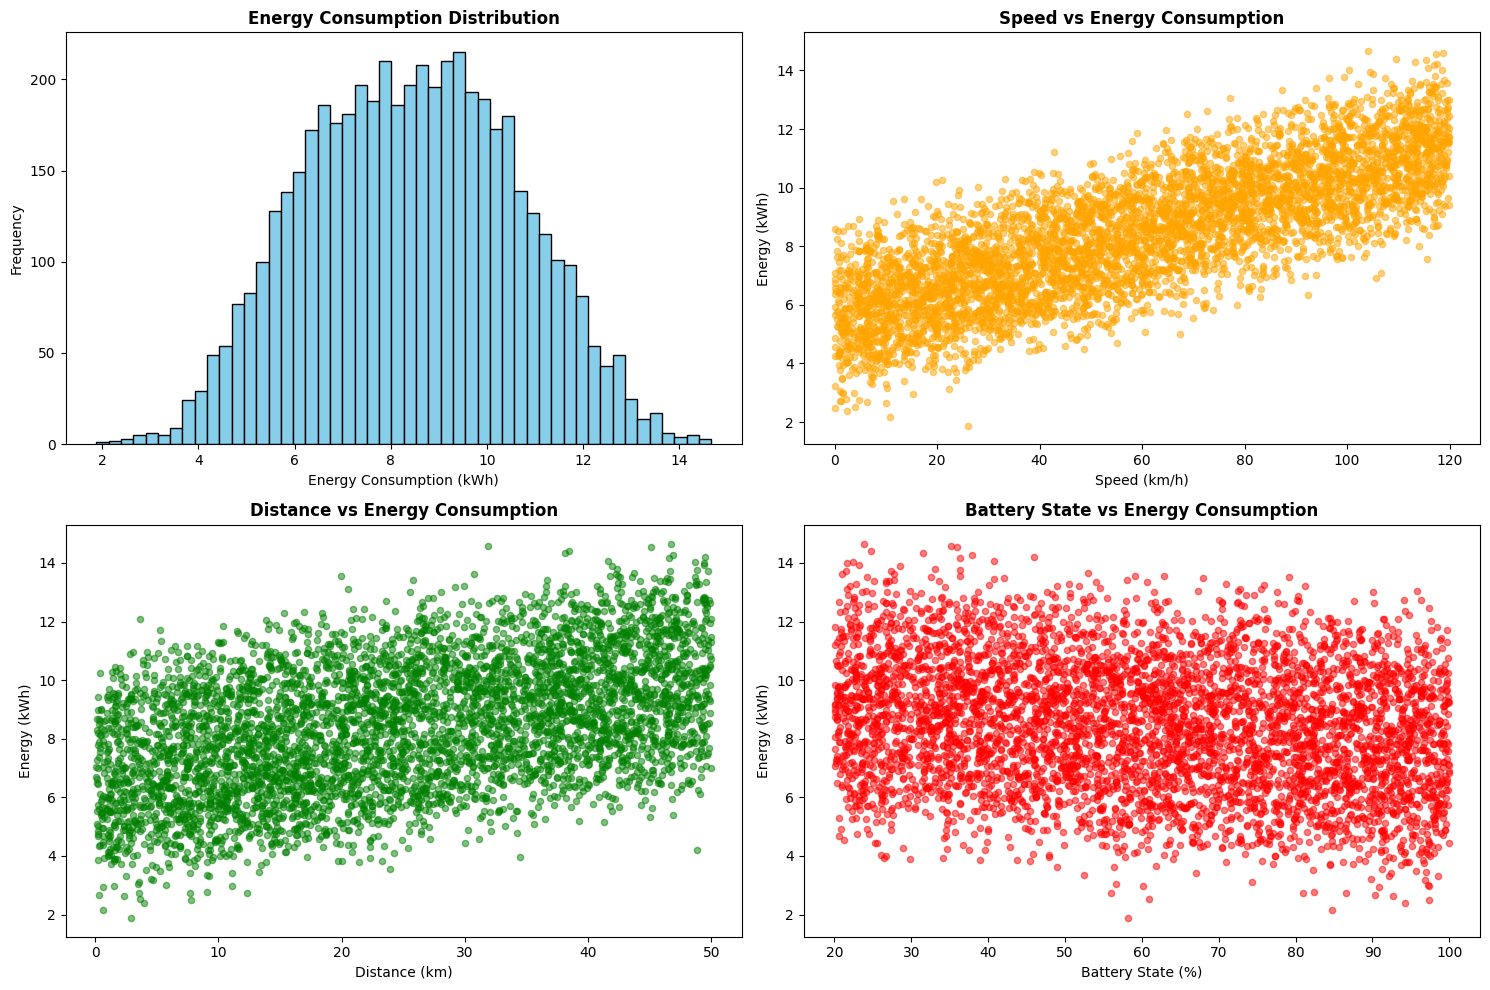

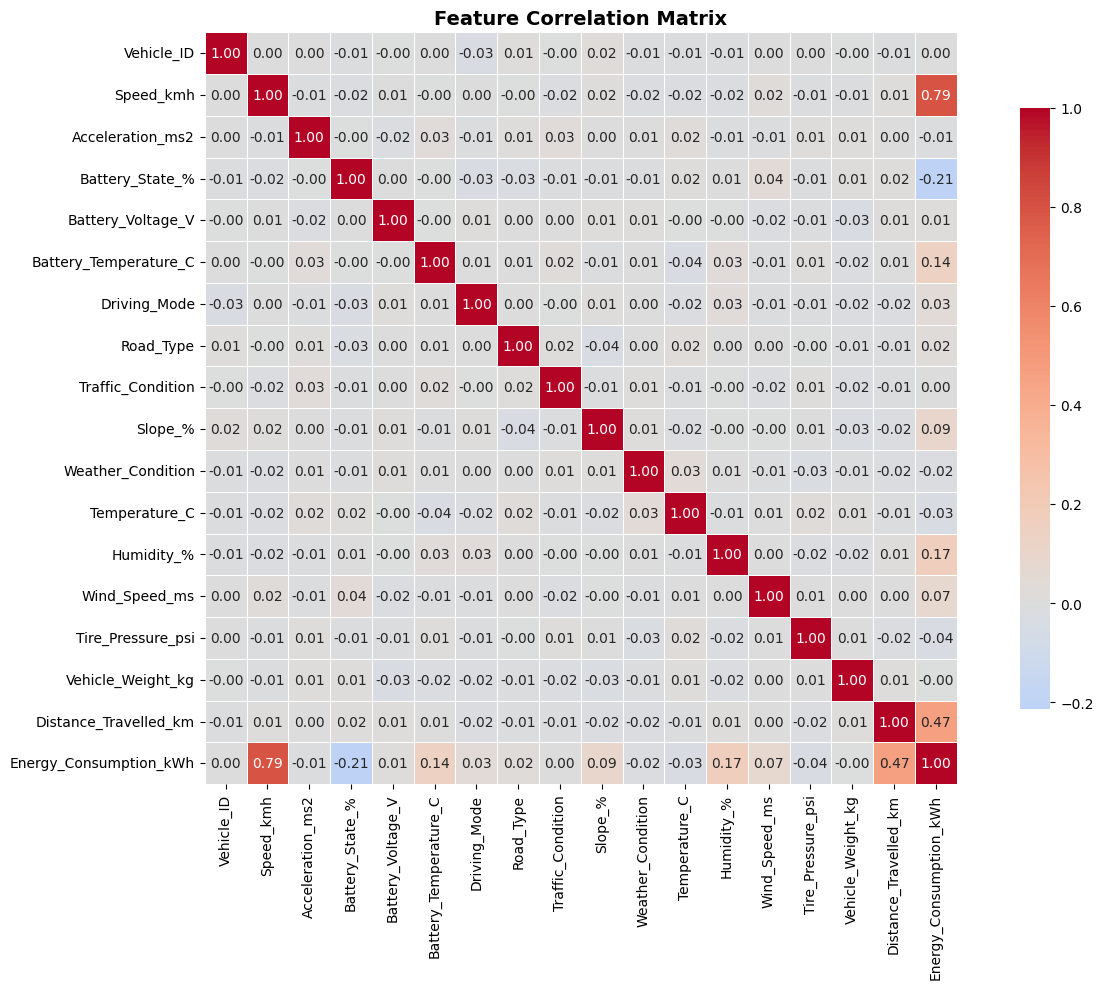

In [24]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Target distribution
axes[0, 0].hist(df['Energy_Consumption_kWh'], bins=50, edgecolor='black', color='skyblue')
axes[0, 0].set_title('Energy Consumption Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Energy Consumption (kWh)')
axes[0, 0].set_ylabel('Frequency')

# Speed vs Energy
axes[0, 1].scatter(df['Speed_kmh'], df['Energy_Consumption_kWh'], alpha=0.5, s=20, color='orange')
axes[0, 1].set_title('Speed vs Energy Consumption', fontweight='bold')
axes[0, 1].set_xlabel('Speed (km/h)')
axes[0, 1].set_ylabel('Energy (kWh)')

# Distance vs Energy
axes[1, 0].scatter(df['Distance_Travelled_km'], df['Energy_Consumption_kWh'], alpha=0.5, s=20, color='green')
axes[1, 0].set_title('Distance vs Energy Consumption', fontweight='bold')
axes[1, 0].set_xlabel('Distance (km)')
axes[1, 0].set_ylabel('Energy (kWh)')

# Battery State vs Energy
axes[1, 1].scatter(df['Battery_State_%'], df['Energy_Consumption_kWh'], alpha=0.5, s=20, color='red')
axes[1, 1].set_title('Battery State vs Energy Consumption', fontweight='bold')
axes[1, 1].set_xlabel('Battery State (%)')
axes[1, 1].set_ylabel('Energy (kWh)')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(14, 10))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Data Preprocessing
Convert timestamps from text to datetime format and extract meaningful time features with cyclical encoding to improve model understanding of temporal patterns.


In [25]:
print("\n" + "="*60)
print("DATA PREPROCESSING")
print("="*60)

# Create a copy for preprocessing
df_processed = df.copy()

# Convert timestamp to datetime
df_processed['Timestamp'] = pd.to_datetime(df_processed['Timestamp'])

# Extract temporal features from timestamp
print("\nExtracting temporal features...")
df_processed['Year'] = df_processed['Timestamp'].dt.year
df_processed['Month'] = df_processed['Timestamp'].dt.month
df_processed['Day'] = df_processed['Timestamp'].dt.day
df_processed['Hour'] = df_processed['Timestamp'].dt.hour
df_processed['Minute'] = df_processed['Timestamp'].dt.minute
df_processed['DayOfWeek'] = df_processed['Timestamp'].dt.dayofweek
df_processed['DayOfYear'] = df_processed['Timestamp'].dt.dayofyear
df_processed['WeekOfYear'] = df_processed['Timestamp'].dt.isocalendar().week.astype(int)

# Cyclical encoding for temporal features (important for time-based patterns)
print("Applying cyclical encoding for temporal features...")
df_processed['Hour_sin'] = np.sin(2 * np.pi * df_processed['Hour'] / 24)
df_processed['Hour_cos'] = np.cos(2 * np.pi * df_processed['Hour'] / 24)
df_processed['DayOfWeek_sin'] = np.sin(2 * np.pi * df_processed['DayOfWeek'] / 7)
df_processed['DayOfWeek_cos'] = np.cos(2 * np.pi * df_processed['DayOfWeek'] / 7)
df_processed['Month_sin'] = np.sin(2 * np.pi * df_processed['Month'] / 12)
df_processed['Month_cos'] = np.cos(2 * np.pi * df_processed['Month'] / 12)



DATA PREPROCESSING

Extracting temporal features...
Applying cyclical encoding for temporal features...


## Feature Engineering
Create new informative features based on physics, interactions, polynomial terms, rolling statistics, and lag values; encode categorical variables numerically.

In [26]:
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# 1. Physics-based features
print("\n1. Creating physics-based features...")

# Power consumption rate (kWh per km)
df_processed['Energy_per_km'] = df_processed['Energy_Consumption_kWh'] / (df_processed['Distance_Travelled_km'] + 1e-6)

# Speed efficiency
df_processed['Speed_Distance_Ratio'] = df_processed['Speed_kmh'] / (df_processed['Distance_Travelled_km'] + 1e-6)

# Battery health indicator
df_processed['Battery_Voltage_Temp_Ratio'] = df_processed['Battery_Voltage_V'] / (df_processed['Battery_Temperature_C'] + 1)

# Kinetic energy proxy
df_processed['Kinetic_Energy_Proxy'] = 0.5 * df_processed['Vehicle_Weight_kg'] * (df_processed['Speed_kmh'] ** 2)

# 2. Interaction features
print("2. Creating interaction features...")
df_processed['Speed_Weight_Interaction'] = df_processed['Speed_kmh'] * df_processed['Vehicle_Weight_kg']
df_processed['Speed_Slope_Interaction'] = df_processed['Speed_kmh'] * df_processed['Slope_%']
df_processed['Battery_State_Voltage'] = df_processed['Battery_State_%'] * df_processed['Battery_Voltage_V']
df_processed['Temp_Humidity_Interaction'] = df_processed['Temperature_C'] * df_processed['Humidity_%']

# 3. Polynomial features for important variables
print("3. Creating polynomial features...")
df_processed['Speed_Squared'] = df_processed['Speed_kmh'] ** 2
df_processed['Speed_Cubed'] = df_processed['Speed_kmh'] ** 3
df_processed['Acceleration_Squared'] = df_processed['Acceleration_ms2'] ** 2
df_processed['Distance_Squared'] = df_processed['Distance_Travelled_km'] ** 2

# 4. Aggregated features (rolling statistics)
print("4. Creating rolling window features...")
# Sort by timestamp and vehicle_id
df_processed = df_processed.sort_values(['Vehicle_ID', 'Timestamp']).reset_index(drop=True)

# Rolling mean features
window_sizes = [3, 5, 10]
for window in window_sizes:
    df_processed[f'Speed_Rolling_Mean_{window}'] = df_processed.groupby('Vehicle_ID')['Speed_kmh'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean())
    df_processed[f'Energy_Rolling_Mean_{window}'] = df_processed.groupby('Vehicle_ID')['Energy_Consumption_kWh'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean())
    df_processed[f'Battery_State_Rolling_Mean_{window}'] = df_processed.groupby('Vehicle_ID')['Battery_State_%'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean())

# Rolling standard deviation
df_processed['Speed_Rolling_Std_5'] = df_processed.groupby('Vehicle_ID')['Speed_kmh'].transform(
    lambda x: x.rolling(window=5, min_periods=1).std())
df_processed['Acceleration_Rolling_Std_5'] = df_processed.groupby('Vehicle_ID')['Acceleration_ms2'].transform(
    lambda x: x.rolling(window=5, min_periods=1).std())

# 5. Lag features
print("5. Creating lag features...")
lag_periods = [1, 2, 3, 5]
for lag in lag_periods:
    df_processed[f'Energy_Lag_{lag}'] = df_processed.groupby('Vehicle_ID')['Energy_Consumption_kWh'].shift(lag)
    df_processed[f'Speed_Lag_{lag}'] = df_processed.groupby('Vehicle_ID')['Speed_kmh'].shift(lag)
    df_processed[f'Battery_State_Lag_{lag}'] = df_processed.groupby('Vehicle_ID')['Battery_State_%'].shift(lag)

# 6. Differential features
print("6. Creating differential features...")
df_processed['Speed_Diff'] = df_processed.groupby('Vehicle_ID')['Speed_kmh'].diff()
df_processed['Battery_State_Diff'] = df_processed.groupby('Vehicle_ID')['Battery_State_%'].diff()
df_processed['Energy_Diff'] = df_processed.groupby('Vehicle_ID')['Energy_Consumption_kWh'].diff()

# 7. Categorical encoding
print("7. Encoding categorical features...")
# One-hot encoding for categorical variables
df_processed = pd.get_dummies(df_processed, columns=['Driving_Mode', 'Road_Type',
                                                       'Traffic_Condition', 'Weather_Condition'],
                               prefix=['DrivingMode', 'RoadType', 'Traffic', 'Weather'],
                               drop_first=False)

# Fill NaN values created by lag and rolling features with 0
df_processed = df_processed.fillna(0)

print(f"\nTotal features after engineering: {df_processed.shape[1]}")


FEATURE ENGINEERING

1. Creating physics-based features...
2. Creating interaction features...
3. Creating polynomial features...
4. Creating rolling window features...
5. Creating lag features...
6. Creating differential features...
7. Encoding categorical features...

Total features after engineering: 80


## Feature Selection
Use a Random Forest model to assess and rank feature importance, then select the most influential features to enhance model performance.


FEATURE SELECTION

Feature matrix shape: (5000, 76)
Target variable shape: (5000,)

Top 20 Most Important Features:
                       feature  importance
34                 Speed_Cubed    0.211334
33               Speed_Squared    0.202717
0                    Speed_kmh    0.191709
36            Distance_Squared    0.099561
11       Distance_Travelled_km    0.094684
38       Energy_Rolling_Mean_3    0.027687
62                 Energy_Diff    0.027038
7                   Humidity_%    0.020881
28        Kinetic_Energy_Proxy    0.018927
2              Battery_State_%    0.018152
31       Battery_State_Voltage    0.012465
41       Energy_Rolling_Mean_5    0.005869
44      Energy_Rolling_Mean_10    0.005532
4        Battery_Temperature_C    0.005424
27  Battery_Voltage_Temp_Ratio    0.004424
48                Energy_Lag_1    0.003796
51                Energy_Lag_2    0.002656
8                Wind_Speed_ms    0.002614
30     Speed_Slope_Interaction    0.002590
26        Speed_Distanc

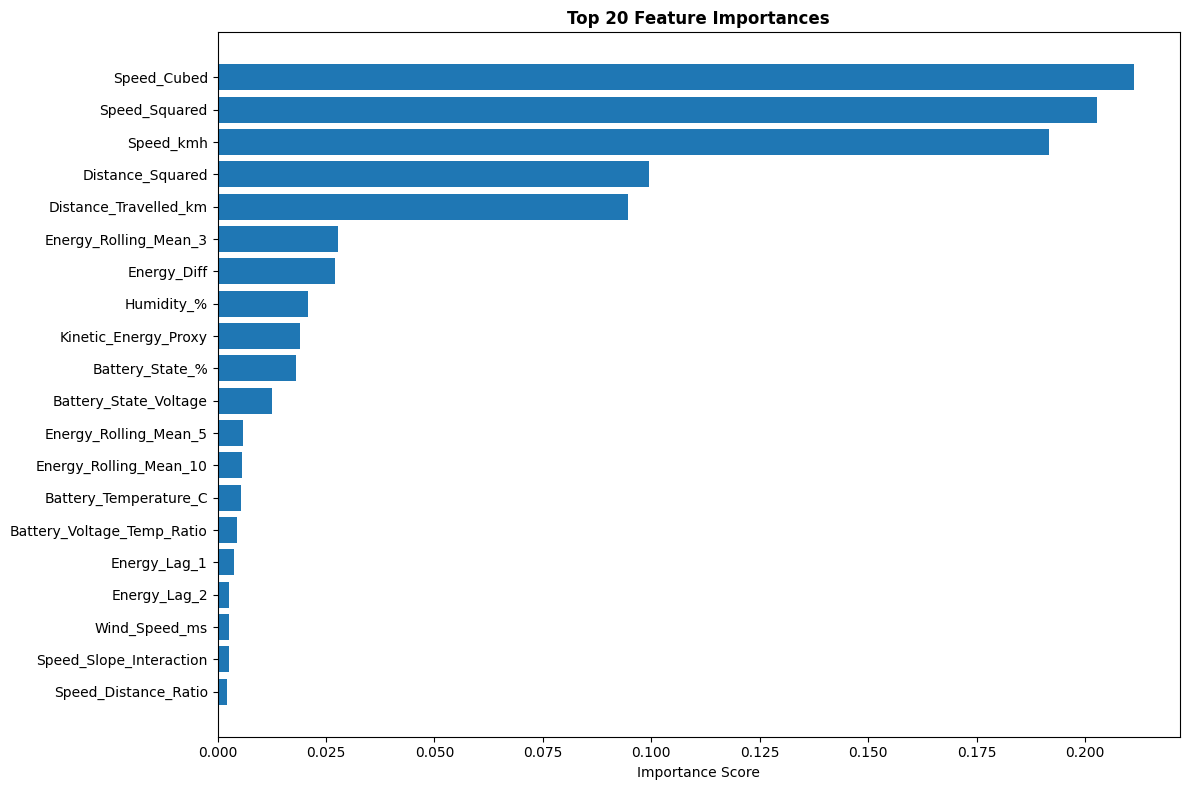


Selected 40 most important features


In [27]:
print("\n" + "="*60)
print("FEATURE SELECTION")
print("="*60)

# Prepare features and target
X = df_processed.drop(['Timestamp', 'Energy_Consumption_kWh', 'Vehicle_ID', 'Energy_per_km'], axis=1)
y = df_processed['Energy_Consumption_kWh']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Check for infinite values and replace them
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Feature importance using Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importances.head(20))

# Visualize top features
plt.figure(figsize=(12, 8))
top_features = feature_importances.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title('Top 20 Feature Importances', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Select top features (you can adjust threshold)
top_n_features = 40
selected_features = feature_importances.head(top_n_features)['feature'].tolist()
X_selected = X[selected_features]

print(f"\nSelected {len(selected_features)} most important features")

## Data Splitting and Scaling
Split data into training and testing sets and scale numeric features to normalize their ranges, enabling effective and faster model training.

In [28]:
print("\n" + "="*60)
print("DATA SPLITTING AND SCALING")
print("="*60)

# Time-series split (important for temporal data)
# Use 80% for training, 20% for testing
split_index = int(len(X_selected) * 0.8)

X_train = X_selected.iloc[:split_index]
X_test = X_selected.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Additional validation split from training data
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

print(f"Final training set: {X_train_final.shape}")
print(f"Validation set: {X_val.shape}")

# Scaling features
print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_final_scaled = scaler.transform(X_train_final)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Also create RobustScaler version (handles outliers better)
robust_scaler = RobustScaler()
X_train_robust = robust_scaler.fit_transform(X_train)
X_test_robust = robust_scaler.transform(X_test)

print("Scaling completed!")



DATA SPLITTING AND SCALING

Training set size: (4000, 40)
Test set size: (1000, 40)
Final training set: (3200, 40)
Validation set: (800, 40)

Scaling features using StandardScaler...
Scaling completed!
